In [1]:
%load_ext autoreload

In [31]:
import mysql.connector as mysql
import numpy as np
import base64
import PIL
from PIL import Image as Image
#from IPython.display import Image
#import urllib.parse
import io
import re
from app.src.db import *
%autoreload 2

In [32]:

mydb = mysql.connect(
    host="127.0.0.1",
    port=49153,
    user="root",
    password="datascience",
    database="racer")


In [33]:
dbcursor = mydb.cursor()


In [41]:
dbcursor.execute("SELECT DISTINCT batchid, layerid, count(*) FROM images GROUP BY batchid, layerid")
results = dbcursor.fetchall()
for result in results:
    print(result)

(5, 0, 2438)
(5, 1, 2437)
(6, 0, 32935)
(6, 1, 3294)
(6, 2, 24070)
(6, 3, 24058)


In [31]:
#createBatch(mydb, "alpha2", "Beginning CNN testing, starting with fresh data.")
getBatches(mydb)

[(5, 'alpha testing', 'Very unstable, no assumptions about consistency'),
 (6, 'alpha2', 'Beginning CNN testing, starting with fresh data.')]

In [19]:
getLayers(mydb)

[(1, 'imageDelta', 'currentframe minus the previous frame', 0, 5)]

In [47]:
#newlayerid = createProcessingLayer(mydb, 0, 6, "imageDeltaWithTDelta", "includes tdelta- ms since last frame")

In [48]:
newlayerid

3

In [38]:
layer=3
batch=6
dbcursor.execute(f"DELETE FROM images WHERE layerid = '{layer}' and batchid = '{batch}'")
mydb.commit()

(74999, 1625443130197, 0.0, 1.5947585820722217, 0.0, 3, 6, 94, '')
(75000, 1625443130269, 0.0, 2.3845773937556363, 0.0, 3, 6, 72, '')
(75001, 1625443130342, -7.277824487440473e-09, 3.1693982317283043, 0.0, 3, 6, 73, '')

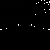
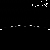
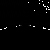

In [59]:
layer=3
batch=6
dbcursor.execute(f"SELECT * FROM images WHERE layerid = '{layer}' and batchid = '{batch}' LIMIT 3")
results = dbcursor.fetchall()
for result in results:
    print(result)


In [37]:
def processorDIFF(targetFrame, referenceFrame):
    return referenceFrame - targetFrame

def process(db, layer, batch, processor, newlayerid=None):
    dbcursor = mydb.cursor()
    dbcursor.execute(f"SELECT * FROM images WHERE layerid = '{layer}' and batchid = '{batch}'")
    lasttime=0
    lastimage_np = None
    results = dbcursor.fetchall()
    print(f"num rows to process: {len(results)}")
    saved_images = 0
    for result in results:
        imageuri = result[8]
        time = result[1]
        position = result[2]
        velocity = result[3]
        rotation = result[4]
        layer    = result[5]
        batch    = result[6]
        
        tdelta = time - lasttime
        lasttime = time
        
        image_np = uriToNP(imageuri)
        if lastimage_np is not None and tdelta <= 255:
            image_diff = processor(lastimage_np, image_np)
            a = np.uint8(image_diff)
            f = io.StringIO()
            newimage = PIL.Image.fromarray(a)
            
            if newlayerid is not None:
                uri_image = pilToURI(newimage)
                
                #display(newimage)
                #showURI(uri_image)
                #print(uri_image)
                try:
                    saveImage(db, batch, newlayerid, time, position, velocity, rotation, uri_image,tdelta=tdelta)
                    saved_images += 1
                except Exception as ex:
                    print(result[0])
                    print("Exception: " + ex)
        lastimage_np = image_np
        
    print(f"saved {saved_images} images into layer {newlayerid} batch {batch}")

In [40]:
process(mydb, 0, 6, processorDIFF, 3)

num rows to process: 24071
saved 24058 images into layer 3 batch 6


In [49]:
def makeVideo(db, layer, batch):
    #this function is broken, use makeGif and then convert the resulting gif into a webm
    import cv2
    import os

    video_name = 'video.avi'
    dbcursor = mydb.cursor()
    dbcursor.execute(f"SELECT * FROM images WHERE layerid = '{layer}' and batchid = '{batch}'")
    results = dbcursor.fetchall()
    #images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    #frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = 50, 50, len(results)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video = cv2.VideoWriter(video_name, 0x7634706d, 1, (300,300))
    for result in results:
        #print(result[7])
        image = uriToNP2(result[8])
        cv2.imshow('frame',image)
        video.write(image)

    cv2.destroyAllWindows()
    video.release()

def makeGif(db, filename, layer, batch):
    
    import imageio
    
    dbcursor = mydb.cursor()
    dbcursor.execute(f"SELECT * FROM images WHERE layerid = '{layer}' and batchid = '{batch}' LIMIT 200")
    results = dbcursor.fetchall()
    #images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    #frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = 50, 50, len(results)
    with imageio.get_writer(filename, mode='I') as writer:
        for result in results:
        #print(result[7])
            image = uriToNP(result[8])
            writer.append_data(image)
        #cv2.imshow('frame',image)
        #video.write(image)

    


def uriToNPXX(imageuri):
    imgstr = re.search(r'base64,(.*)', imageuri).group(1)
    image_bytes = io.BytesIO(base64.b64decode(imgstr))
    im = Image.open(image_bytes)
    nparray = np.array(im)
    if len(nparray.shape) == 2:
        arr = np.array(im)[:,:]
    elif len(nparray.shape) == 3:
        arr = np.array(im)[:,:,0]
    return arr

In [50]:
makeGif(mydb, "deltas.gif",0,6)

In [60]:
np.append(np.array([1,2,3]),4)

array([1, 2, 3, 4])

In [35]:
X, Y = getDataset(mydb, 6, 3)


loaded 100 out of 24063, 0.4155757802435274%   TDeltaCol.shape=(100, 1)
loaded 200 out of 24063, 0.8311515604870549%   TDeltaCol.shape=(200, 1)
loaded 300 out of 24063, 1.2467273407305821%   TDeltaCol.shape=(300, 1)
loaded 400 out of 24063, 1.6623031209741097%   TDeltaCol.shape=(400, 1)
loaded 500 out of 24063, 2.077878901217637%   TDeltaCol.shape=(500, 1)
loaded 600 out of 24063, 2.4934546814611642%   TDeltaCol.shape=(600, 1)
loaded 700 out of 24063, 2.909030461704692%   TDeltaCol.shape=(700, 1)
loaded 800 out of 24063, 3.3246062419482194%   TDeltaCol.shape=(800, 1)
loaded 900 out of 24063, 3.7401820221917466%   TDeltaCol.shape=(900, 1)
loaded 1000 out of 24063, 4.155757802435274%   TDeltaCol.shape=(1000, 1)
loaded 1100 out of 24063, 4.571333582678801%   TDeltaCol.shape=(1100, 1)
loaded 1200 out of 24063, 4.9869093629223284%   TDeltaCol.shape=(1200, 1)
loaded 1300 out of 24063, 5.4024851431658565%   TDeltaCol.shape=(1300, 1)
loaded 1400 out of 24063, 5.818060923409384%   TDeltaCol.sha

In [36]:
print(X.shape)
print(Y.shape)

(24063, 2501)
(24063, 3)


In [92]:
arr

array([[147, 147, 143, ..., 178, 176, 176],
       [142, 139, 138, ..., 181, 180, 178],
       [135, 135, 131, ..., 185, 183, 182],
       ...,
       [178, 178, 178, ..., 178, 178, 178],
       [178, 178, 178, ..., 178, 178, 178],
       [178, 178, 178, ..., 178, 178, 178]], dtype=uint8)

In [93]:
arr.shape

(50, 50)

In [56]:
data.shape

()

In [57]:
data

array(<IPython.core.display.Image object>, dtype=object)